# Lesson/Article 05 - Fake Jobs Predictor

**Author: Gabriel Moretti de Souza - 200018205**

**Author's GitHub username: MorettiGS**

## HuggingFace

The following is the link for the HuggingFace space regarding this notebook:

[HugginFace - FakeJobPost](https://huggingface.co/spaces/MorettiGS/FakeJobPost)

## Objective

In this article, we are going through the creation and usage of a **identifier** using Artificial Intelligence, with the main purpose of training it to determine if a job post is fake or not.

For the creation of said predictor, we will be creating a neural network capable of identifying fake jobs based on 95 columns of data from the kaggle dataset [Fake/Real Job Posting in Nigeria](https://www.kaggle.com/datasets/oyelajairemide/fakereal-job-posting-in-nigeria).

This search and results could be useful, in a real life situation, when trying to avoid professional scams or frauds.

## Pre-requisites

Previous downloads that were necessary for all dependencies used on the notebook:

In [ ]:
# !pip install --upgrade pip setuptools wheel
# !pip install p5py
# !pip install PEP517
# !pip install gcc
# !pip install pandas
# !pip install kaggle
# !pip install opendatasets
# !pip install torch
# !pip install fastai

Before going any further, it is essential that we get the necessary dependencies for the AI training, and these can be found in the Python libraries of **pandas** and **numpy**.
They can be imported with the following python code:

In [5]:
import opendatasets as od # Responsible for dataset download
import numpy as np # Responsible for linear algebra
import pandas as pd # Responsible for data processing and manipulation

## Data

Now we can work on the data that will be used on this AI training. As said before, the data will be obtained by the use of the kaggle dataset. We can download it as follows, using the username and key from kaggle:

In [66]:
od.download(
    "https://www.kaggle.com/datasets/oyelajairemide/fakereal-job-posting-in-nigeria")

# Downloading it by kaggle username and key

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: gmorettis
Your Kaggle Key: ········


100%|██████████| 29.0k/29.0k [00:00<00:00, 361kB/s]

Then, the dataset's columns can be seen organized as follows:

In [71]:
df = pd.read_csv('fakereal-job-posting-in-nigeria/CompiledjobListNigeria.csv')
df

,job_title,company_name,company_desc,job_desc,job_requirement,salary,location,employment_type,department,label
0,Accountant,Equity Model Limited,"Accounting, Auditing & Finance","Compiling, analyzing, and reporting financial data.","This position is open preferably to a male candidate,Minimum academic qualification preferably in accounting,Candidates aged between 22 - 30 years,Ability to write clearly and help with word processing when necessary.,A warm personality and strong communication skills.,Ability to work well under limited supervision.,Great communication and writing skills.,Hands-on experience in managing time and personnel.","75,000 - 150,000",Abuja,Full Time,Law & Compliance,0
1,Content Writer,CLINTON FUND (CF),Management & Business Development,"Creating, improving and maintaining content to achieve our business goals. Your duties will also include sharing content to raise brand awareness and monitoring web traffic and metrics to identify best practices.","Bachelor's degree in Journalism, English, Communications or related field.","60,000 - 100,000",Lagos,Full Time,Content Writing,1
2,Accountant,Schleez Nigeria Limited,"Accounting, Auditing & Finance","Managing financial transactions, preparing financial reports, and providing financial advice to clients.","Minimum of Bachelor's degree in Accounting or related field, Professional certification such as ACCA or ICAN, Proven experience as an Accountant, Strong computer skills, including proficiency in Excel, Excellent communication and interpersonal skills",Negotiable,"First Floor, Left Wing, No. 49, Olowu Street, Off Moboloji Bank, Anthony Way, Ikeja, Lagos State",Full-time,Accounting,1
3,Sales Executive,Bons Industries Limited,Marketing & Communications,"Understanding of the sales process and dynamics.""","Minimum academic qualification of BSC/HND Degree in Marketing and other related disciplines, Minimum of 3years of work experience., Self-motivated and driven by targets., Strong communication skills – including both","75,000 - 150,000",Enugu,Full Time,Manufacturing & Warehousing,0
4,Bulk/Partnership Marketing Officer,TAMAK LOGISTICS,Marketing & Communications,Establish relationships with major businesses situated on the island,"Be smart & resourceful.,Great knowledge of how to socialize and interact with the major businesses & vendors.,Have a working smartphone.,Be well-spoken & presentable.,The ability to work with minimal / no supervision.,Be able to use Microsoft office tools.,Age preference is between 21-28 years.","Less than 75,000",Lagos,Full Time,Shipping & Logistics,0
...,...,...,...,...,...,...,...,...,...,...
197,Project Manager,HOME PLACES CONSULT,Management & Business Development,Oversee construction projects,Bachelor's Degree in Engineering or related field,"400,000",Lagos,Full Time,Construction,1
198,Accountant,Jobberman (Third Party Recruitment),"Accounting, Auditing & Finance",Handle postings of all accounting transactions.,"This position is open preferably to a female candidate,Minimum academic qualification of a first degree, BSc/HND in Accounting.,ACA/ACCA (Chartered Accountant) Certification.,3 - 5 years of work experience in a Chartered Accounting Firm.,Experience in financial reporting,Excellent research and reporting skills.,Detail-oriented and time management skills.","250,000 - 400,000",Abuja,Full Time,IT & Telecoms,0
199,Customer Care Representative,CAKES AND CREAM,Customer Service & Support,Manage large amounts of incoming calls,"Minimum academic qualification of a BSc/ equivalent in any field,Must have completed NYSC,Male /female,Experience in customer service","75,000 - 150,000",Lagos,Full Time,Hospitality & Hotel,0
200,Business Development Manager,BETA AGE,Management & Business Development,Conduct research to identify business opportunities and evaluate market trends. Develop and implement business strategies to achieve growth objectives.Establish and maintain relationships with clients and partners. Coordinate and manage projects fro

Where 'BodyFat' is the column responsible for the class of the given data, acting as a label for future classification. The other columns represent data from measurement and other information on the human body, going from neck to ankle, with also age, weight and body density.

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   job_title        202 non-null    object
 1   company_name     202 non-null    object
 2   company_desc     202 non-null    object
 3   job_desc         202 non-null    object
 4   job_requirement  202 non-null    object
 5   salary           202 non-null    object
 6   location         202 non-null    object
 7   employment_type  202 non-null    object
 8   department       202 non-null    object
 9   label            202 non-null    int64 
dtypes: int64(1), object(9)
memory usage: 15.9+ KB


<AxesSubplot:>

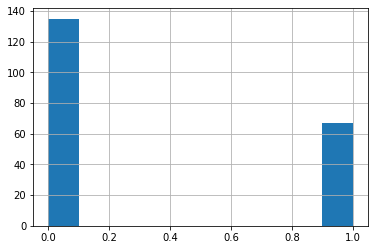

In [123]:
df['label'].hist()

In [73]:
df.isna().sum()

job_title          0
company_name       0
company_desc       0
job_desc           0
job_requirement    0
salary             0
location           0
employment_type    0
department         0
label              0
dtype: int64

We can also see that the dataset doesn't have any null values.

Now we can encode all the strings on the dataset for easier future usage:

In [74]:
# Encoding strings

from sklearn.preprocessing import LabelEncoder
import pandas as pd
label_encoder = LabelEncoder()

for column in df.columns[:-1]:  # Exclude the last column (label)
    df[column] = label_encoder.fit_transform(df[column])
    
df

,job_title,company_name,company_desc,job_desc,job_requirement,salary,location,employment_type,department,label
0,3,44,0,19,183,35,4,1,26,0
1,25,16,26,34,1,31,19,1,10,1
2,3,111,0,112,133,46,8,2,0,1
3,104,11,29,180,69,35,6,1,28,0
4,11,120,29,67,49,44,19,1,38,0
...,...,...,...,...,...,...,...,...,...,...
197,96,57,26,126,15,25,19,1,9,1
198,3,65,0,82,179,17,4,1,24,0
199,30,15,12,106,101,35,19,1,22,0
200,13,7,26,0,134,4,19,1,8,1


## Tensor creation

In [75]:
# Creating tensor for dependent row (label)
import torch
t_dep = tensor(df.label)

Creating independent columns:

In [76]:
indep_cols = df.columns[:-1] # Get all elements except the label

# Create tensor for independent rows
t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep

tensor([[  3.,  44.,   0.,  ...,   4.,   1.,  26.],
        [ 25.,  16.,  26.,  ...,  19.,   1.,  10.],
        [  3., 111.,   0.,  ...,   8.,   2.,   0.],
        ...,
        [ 30.,  15.,  12.,  ...,  19.,   1.,  22.],
        [ 13.,   7.,  26.,  ...,  19.,   1.,   8.],
        [ 39.,  35.,  13.,  ...,  19.,   1.,  24.]])

In [77]:
# Number of independent columns and rows
t_indep.shape

torch.Size([202, 9])

## Model creation

In [78]:
# Defining random coefficients for the columns
torch.manual_seed(442)

n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)-0.5
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,
         0.2799])

In [79]:
# Multiplying columns by the coefficients
t_indep*coeffs

tensor([[ -1.3887,   6.0975,   0.0000,  ...,   1.9504,   0.3136,   7.2770],
        [-11.5725,   2.2173,   6.2634,  ...,   9.2646,   0.3136,   2.7988],
        [ -1.3887,  15.3823,   0.0000,  ...,   3.9009,   0.6271,   0.0000],
        ...,
        [-13.8870,   2.0787,   2.8908,  ...,   9.2646,   0.3136,   6.1574],
        [ -6.0177,   0.9701,   6.2634,  ...,   9.2646,   0.3136,   2.2391],
        [-18.0531,   4.8503,   3.1317,  ...,   9.2646,   0.3136,   6.7172]])

In [80]:
# Dividing by the max value
vals,indices = t_indep.max(dim=0)
t_indep = t_indep / vals

t_indep*coeffs

tensor([[-0.0110,  0.0426,  0.0000,  ...,  0.0406,  0.0784,  0.1775],
        [-0.0918,  0.0155,  0.1362,  ...,  0.1930,  0.0784,  0.0683],
        [-0.0110,  0.1076,  0.0000,  ...,  0.0813,  0.1568,  0.0000],
        ...,
        [-0.1102,  0.0145,  0.0628,  ...,  0.1930,  0.0784,  0.1502],
        [-0.0478,  0.0068,  0.1362,  ...,  0.1930,  0.0784,  0.0546],
        [-0.1433,  0.0339,  0.0681,  ...,  0.1930,  0.0784,  0.1638]])

## Prediction creation

In [81]:
preds = (t_indep*coeffs).sum(axis=1)
preds[:10]

tensor([-0.1936,  0.1444, -0.3053, -0.4462,  0.3063, -0.3307,  0.0495, -0.0966,
        -0.0051, -0.1639])

## Loss creation

In [82]:
loss = torch.abs(preds-t_dep).mean()
loss

tensor(0.4297)

## Prediction and loss as functions

In [83]:
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

## Gradients

In [84]:
# Gradient calculation
coeffs.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,
         0.2799], requires_grad=True)

In [85]:
# Calculate loss with coeffs
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.4297, grad_fn=<MeanBackward0>)

In [86]:
loss.backward()

In [87]:
coeffs.grad

tensor([-0.3529, -0.2659, -0.2766, -0.3537, -0.3225, -0.3941, -0.2130, -0.2092,
        -0.2908])

In [88]:
# Checking tensor
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

tensor([-0.7059, -0.5317, -0.5532, -0.7073, -0.6450, -0.7882, -0.4259, -0.4183,
        -0.5815])

In [89]:
# Gradient accompanies loss
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    coeffs.grad.zero_()
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.3803)


## Model training

In [90]:
# Getting dataset
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(ds)

In [91]:
# Applying indices
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]
len(trn_indep),len(val_indep)

(162, 40)

In [92]:
# Creating auxiliary functions
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()
    
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")
    
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

In [93]:
# Training model
coeffs = train_model(18, lr=0.2)

0.402; 0.337; 0.329; 0.326; 0.324; 0.322; 0.319; 0.317; 0.314; 0.312; 0.309; 0.307; 0.305; 0.304; 0.307; 0.306; 0.303; 0.301; 

In [94]:
# Showing all the coefficients
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'job_title': tensor(-0.2496),
 'company_name': tensor(0.0365),
 'company_desc': tensor(0.1523),
 'job_desc': tensor(-0.0401),
 'job_requirement': tensor(-0.1318),
 'salary': tensor(-0.2531),
 'location': tensor(0.4860),
 'employment_type': tensor(0.5228),
 'department': tensor(0.2245)}

## Accuracy

In [95]:
# Calculating predictions
preds = calc_preds(coeffs, val_indep)
preds

tensor([ 0.0695,  0.1985,  0.0334,  0.0475, -0.0662,  0.1778,  0.1223,  0.5476,
         0.4913,  0.0193,  0.3754,  0.2398,  0.4735,  0.4955,  0.6243,  0.2094,
         0.3382,  0.1748,  0.3310,  0.2241,  0.1762,  0.5074,  0.1041,  0.4231,
         0.6347,  0.3914,  0.1985,  0.8192,  0.3252,  0.3899, -0.0399,  0.1142,
         0.0135,  0.7376,  0.2127,  0.3538,  0.3639,  0.2303,  0.0750,  0.3555])

In [96]:
# Judging results based on a margin of 0.5 on the overall results
results = val_dep.bool()==(preds>0.5)
results[:16]

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True, False, False,  True, False])

In [97]:
# Checking accuracy
results.float().mean()

tensor(0.6250)

In [98]:
# Function for acc calculation
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(0.6250)

## Sigmoid

In [99]:
# Predictions
preds[:28]

tensor([ 0.0695,  0.1985,  0.0334,  0.0475, -0.0662,  0.1778,  0.1223,  0.5476,
         0.4913,  0.0193,  0.3754,  0.2398,  0.4735,  0.4955,  0.6243,  0.2094,
         0.3382,  0.1748,  0.3310,  0.2241,  0.1762,  0.5074,  0.1041,  0.4231,
         0.6347,  0.3914,  0.1985,  0.8192])

In [100]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))

In [101]:
coeffs = train_model(lr=100)

0.474; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 

In [102]:
show_coeffs()

{'job_title': tensor(-6.2340),
 'company_name': tensor(-5.0230),
 'company_desc': tensor(-5.7885),
 'job_desc': tensor(-6.5299),
 'job_requirement': tensor(-6.5034),
 'salary': tensor(-10.1042),
 'location': tensor(-3.1994),
 'employment_type': tensor(-1.2366),
 'department': tensor(-6.0760)}

In [103]:
(val_indep*coeffs).sum(axis=1)

tensor([-18.9257, -25.1557, -30.0668, -18.0933, -23.1702, -28.1749, -28.0076,
        -32.1991, -22.9469, -26.4017, -29.7757, -18.3661, -24.2238, -25.0910,
        -21.5555, -19.2861, -33.0477, -19.8393, -25.6675, -26.7142, -26.6132,
        -25.8702, -33.9694, -19.2661, -25.4632, -16.6679, -28.8890, -22.8700,
        -22.7133, -29.5223, -25.6798, -34.2988, -15.7748, -24.6730, -30.8681,
        -27.8849, -19.9512, -33.3615, -19.4512, -31.4564])

In [104]:
val_indep@coeffs

tensor([-18.9257, -25.1557, -30.0668, -18.0933, -23.1702, -28.1749, -28.0076,
        -32.1991, -22.9469, -26.4017, -29.7757, -18.3661, -24.2238, -25.0910,
        -21.5555, -19.2861, -33.0477, -19.8393, -25.6675, -26.7142, -26.6132,
        -25.8702, -33.9694, -19.2661, -25.4632, -16.6679, -28.8890, -22.8700,
        -22.7133, -29.5223, -25.6798, -34.2988, -15.7748, -24.6730, -30.8681,
        -27.8849, -19.9512, -33.3615, -19.4512, -31.4564])

In [105]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)

In [106]:
def init_coeffs(): return (torch.rand(n_coeff, 1)*0.1).requires_grad_()

In [107]:
trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]

In [108]:
coeffs = train_model(lr=100)

0.523; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 

In [109]:
acc(coeffs)

tensor(0.4750)

## Neural Network

In [110]:
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden
    layer2 = torch.rand(n_hidden, 1)-0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

In [111]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    l1,l2,const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

In [112]:
def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

### Training model

In [113]:
coeffs = train_model(lr=1.4)

0.570; 0.552; 0.530; 0.505; 0.474; 0.438; 0.399; 0.363; 0.336; 0.319; 0.309; 0.302; 0.298; 0.295; 0.293; 0.291; 0.290; 0.289; 0.289; 0.288; 0.287; 0.287; 0.287; 0.286; 0.286; 0.286; 0.286; 0.285; 0.285; 0.285; 

In [114]:
coeffs = train_model(lr=20)

0.570; 0.349; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 0.284; 

In [115]:
acc(coeffs)

tensor(0.4750)

In [116]:
def init_coeffs():
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

In [117]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return torch.sigmoid(res)

In [118]:
def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [119]:
coeffs = train_model(lr=4)

0.645; 0.470; 0.427; 0.393; 0.369; 0.352; 0.340; 0.331; 0.324; 0.319; 0.315; 0.312; 0.309; 0.307; 0.305; 0.304; 0.302; 0.301; 0.300; 0.299; 0.298; 0.298; 0.297; 0.296; 0.296; 0.295; 0.295; 0.294; 0.294; 0.294; 

In [120]:
acc(coeffs)

tensor(0.4750)

## Saving model for use

In [124]:
torch.save(coeffs, 'fakejobposts.pth')